## Sequence Clustering

This notebook contains step by step process to generate event sequence clusters.

In [ ]:
# install libraries required for sequence embedding
!pip install sgt
!pip install pandarallel

In [ ]:
# general
from tqdm import tqdm
import pandas as pd
import numpy as np

# sequence embedding
import sgt
from sgt import SGT
import pandarallel

# dimension reduction and clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

### Data Preprocessing

In [ ]:
# load data
df_orig = pd.read_csv('dt_event_seq_10000_5_1.csv')

In [ ]:
# Set ID
df_orig['ID'] = range(0, len(df_orig))

In [ ]:
df_orig.head()

,event_seq,occurrence_count,unique_users,mean_seq_time,seq_length,ID
0,servicedesk.page.view.queue#-#servicedesk.page...,9,6,1,3,0
1,experiments.performance.inclusion#-#dashboardview,1002,153,34,2,1
2,jira.header.menu.opened#-#jira.header.menu.closed,257,96,1701,2,2
3,kickass.criteriaAutoUpdateEnabled#-#kickass.vi...,1941,211,4658,4,3
4,kickass.criteriaAutoUpdateEnabled#-#browserWin...,131,44,5548,5,4


In [ ]:
df = df_orig.loc[:, ['ID', 'event_seq']]
df.columns = ['id', 'sequence']
df['sequence'] = df['sequence'].apply(lambda x: x.split('#-#'))

### Sequence Embedding

In [ ]:
sgt_ = SGT(kappa=1, 
           lengthsensitive=False, 
           mode='multiprocessing')
sgtembedding_df = sgt_.fit_transform(df)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
sgtembedding_df = sgtembedding_df.set_index('id')

In [ ]:
sgtembedding_df.head()

,"(ace.stp.open, ace.stp.open)","(ace.stp.open, ace.stp.open.icon)","(ace.stp.open, administration.navigate.tabs)","(ace.stp.open, administration.project.summary)","(ace.stp.open, administration.projectconfig.workflow.loadworkflowstab)","(ace.stp.open, administration.projects.components.component.created.inline)","(ace.stp.open, administration.projects.components.component.created.rest)","(ace.stp.open, administration.projects.versions.version.created.rest)","(ace.stp.open, administration.workflow.draftpublished)","(ace.stp.open, administration.workflow.edit)","(ace.stp.open, administration.workflow.open.edit.global)","(ace.stp.open, administration.workflow.selectmode)","(ace.stp.open, administration.workflow.updated)","(ace.stp.open, browseproject.administerproject)","(ace.stp.open, browseproject.issuefilter.all)","(ace.stp.open, browser.metrics.domContentLoadedEventEnd)","(ace.stp.open, browser.metrics.domContentLoadedEventStart)","(ace.stp.open, browser.metrics.experimentalMainJsDuration)","(ace.stp.open, browser.metrics.loadEventEnd)","(ace.stp.open, browser.metrics.navigation)","(ace.stp.open, browser.metrics.requestStart)","(ace.stp.open, browser.metrics.responseEnd)","(ace.stp.open, browser.metrics.responseStart)","(ace.stp.open, browser.metrics.secureConnectionStart)","(ace.stp.open, browserWindowSize)","(ace.stp.open, connect.addon.bridge.invokemethod)","(ace.stp.open, connect.addon.iframe.performance.load)","(ace.stp.open, connect.scoped.request.incoming.allowed)","(ace.stp.open, dashboardview)","(ace.stp.open, devstatus.commits.detail.github.commit.clicked)","(ace.stp.open, devstatus.commits.summary.clicked)","(ace.stp.open, devstatus.summary.shown.assignee)","(ace.stp.open, devstatus.summary.shown.nonassignee)","(ace.stp.open, experiments.performance.inclusion)","(ace.stp.open, gh.issueaction.issuedetail.assign-issue)","(ace.stp.open, gh.issueaction.issuedetail.editIssue)","(ace.stp.open, gh.issueaction.keyboardshortcuts.assign-issue)","(ace.stp.open, gh.issuedetail.inlineedit)","(ace.stp.open, gh.quickcreate.create)","(ace.stp.open, gh.rapidboard.epics.epicCount)",...,"(workstartedonissue, kickass.filterChangesSaved)","(workstartedonissue, kickass.inlineEdit)","(workstartedonissue, kickass.issueLoadDuration)","(workstartedonissue, kickass.issueTableRefresh)","(workstartedonissue, kickass.moreCriteriaNewlySelectedCount)","(workstartedonissue, kickass.navigateToIssueNavigator)","(workstartedonissue, kickass.openIssueFromTable)","(workstartedonissue, kickass.queryTooComplexSwitchToAdvanced)","(workstartedonissue, kickass.reloadPage)","(workstartedonissue, kickass.returntosearch)","(workstartedonissue, kickass.saveACopyOfFilterFromSearchHeader)","(workstartedonissue, kickass.sortByColumn)","(workstartedonissue, kickass.viewIssue)","(workstartedonissue, lexorankbalance)","(workstartedonissue, mentionissue)","(workstartedonissue, mentionissuecomment)","(workstartedonissue, mobile.element.click)","(workstartedonissue, projectcomponentcreated)","(workstartedonissue, quick.create.fields)","(workstartedonissue, quickbrowse)","(workstartedonissue, quicksearch)","(workstartedonissue, remoteissuelinkcreate)","(workstartedonissue, report.viewed)","(workstartedonissue, servicedesk.page.view.agent.session)","(workstartedonissue, servicedesk.page.view.customerview.allrequests)","(workstartedonissue, servicedesk.page.view.customerview.allrequests.ownselected)","(workstartedonissue, servicedesk.page.view.customerview.attachment)","(workstartedonissue, servicedesk.page.view.customerview.comment)","(workstartedonissue, servicedesk.page.view.customerview.login)","(workstartedonissue, servicedesk.page.view.customerview.requestDetails)","(workstartedonissue, servicedesk.page.view.customerview.session)","(workstartedonissue, servicedesk.page.view.header.sd.topmenu)","(workstartedonissue, servicedesk.page.view.queue)","(workstartedonissue, servicedesk.page.view.queues)","(workstartedonissue, servicedesk.page.view.servicedesk.queue.issue.vi

### Dimension Reduction

In [ ]:
pca = PCA(n_components=2)
pca.fit(sgtembedding_df)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
X = pca.transform(sgtembedding_df)
print(np.sum(pca.explained_variance_ratio_))

0.18866847245978535


In [ ]:
df_pca = pd.DataFrame(data=X, columns=['x1', 'x2'])


### Clustering

First we select optimal number of clusters using elbow clustering technique.

In [ ]:
# Elbow clustering

distortions = []
K_max = 50
for k in tqdm(range(1, K_max)):

  kmeans = KMeans(n_clusters=k)
  kmeans.fit(df_pca)
  distortions.append(kmeans.inertia_)


In [ ]:
plt.figure()
plt.plot(range(1, K_max), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Based on above elbow plot, we can see k=5 seems a reasonable for final clustering.

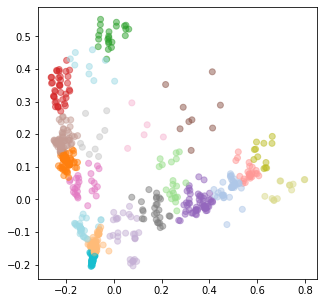

In [ ]:
n_clusters = 20

kmeans = KMeans(n_clusters=n_clusters, max_iter =300)
kmeans.fit(df_pca)

labels = kmeans.predict(df_pca)
centroids = kmeans.cluster_centers_

# cm = plt.get_cmap('Dark2')
cm = plt.get_cmap('tab20')
colmap = {i: cm(i) for i in range(1, n_clusters+1)}

fig = plt.figure(figsize=(5, 5))
colors = list(map(lambda x: colmap[x+1], labels))
scatter = plt.scatter(df_pca['x1'], df_pca['x2'], label = labels, color=colors, alpha=0.5, edgecolor=colors)


### Cluster Outcomes

In [ ]:
df_orig['cluster_id'] = labels
df_orig['pca_x1'] = df_pca['x1']
df_orig['pca_x2'] = df_pca['x2']
df_orig['event_seq_cont'] = df_orig['event_seq'].apply(lambda x: x.split('#-#'))

In [ ]:
df_orig.head()

,event_seq,occurrence_count,unique_users,mean_seq_time,seq_length,ID,cluster_id,pca_x1,pca_x2,event_seq_cont
0,servicedesk.page.view.queue#-#servicedesk.page...,9,6,1,3,0,2,-0.081649,-0.153496,"[servicedesk.page.view.queue, servicedesk.page..."
1,experiments.performance.inclusion#-#dashboardview,1002,153,34,2,1,2,-0.080295,-0.159585,"[experiments.performance.inclusion, dashboardv..."
2,jira.header.menu.opened#-#jira.header.menu.closed,257,96,1701,2,2,17,-0.086909,-0.170163,"[jira.header.menu.opened, jira.header.menu.clo..."
3,kickass.criteriaAutoUpdateEnabled#-#kickass.vi...,1941,211,4658,4,3,0,0.491255,0.036603,"[kickass.criteriaAutoUpdateEnabled, kickass.vi..."
4,kickass.criteriaAutoUpdateEnabled#-#browserWin...,131,44,5548,5,4,3,-0.023842,0.459916,"[kickass.criteriaAutoUpdateEnabled, browserWin..."


In [ ]:
df_orig.to_csv('dt_event_seq_10000_5_1_k20.csv', index = None)

In [ ]:
cluster_events = {}

for i in range(0, n_clusters):

  df_c1 = df_orig.loc[df_orig['cluster_id']==i]

  c1_events = []
  for index, row in df_c1.iterrows():
    c1_events.extend(row['event_seq_cont'])

  c1_events = list(set(c1_events))
  c1_events.sort()
  cluster_events[i] = c1_events

In [ ]:
cluster_events

In [ ]:
for i in range(0, n_clusters):
  print(i, '-', len(cluster_events[i]))

0 - 117
1 - 33
2 - 34
3 - 15
4 - 15
5 - 20
6 - 13
7 - 19
8 - 12
9 - 18
10 - 23
11 - 22
12 - 32
13 - 14
14 - 17
15 - 15
16 - 10
17 - 17
18 - 13
19 - 33


In [ ]:
df_res = pd.DataFrame(cluster_events.items(), columns=['Cluster', 'Events'])

In [ ]:
df_res.to_csv('cluster_output.csv', index=None)